In [23]:
# Joey Votto analytics(2015-2016)

# ライブラリのインポートと設定
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 100
pd.options.display.max_rows = 300

In [24]:
# 変化球の正式名称(あとで使う)

PITCH_TYPE_NAME = {
    'CH': 'Change-up',
    'CU': 'Curveball',
    'EP': 'Ephuus',
    'FA': 'Fastball',
    'FC': 'Cut Fastball',
    'FF': 'four-seam Fastball',
    'FO': 'Forkball',
    'FS': 'Split-finger Fastball',
    'FT': 'two-seam Fastball',
    'KC': 'Knuckle Curve',
    'KN': 'Knuckleball',
    'SC': 'Screwball',
    'SI': 'Sinker',
    'SL': 'Slider',
    'UN': 'Unknown'
}

In [25]:
# 2015年の一年間および、2016年途中(開幕〜8/31まで)のデータセットを取る
votto_atbat_2015 = pd.read_csv('./output/player_stats/joey_votto_2015_atbat.csv')
votto_pitchfx_2015 = pd.read_csv('./output/player_stats/joey_votto_2015_pitch.csv')
votto_atbat_2016 = pd.read_csv('./output/player_stats/joey_votto_2016_atbat.csv')
votto_pitchfx_2016 = pd.read_csv('./output/player_stats/joey_votto_2016_pitch.csv')


In [26]:
# 時系列分析用に試合の日(game_day)および、変化球の正式名称を加える
for df in (votto_atbat_2015, votto_atbat_2016, votto_pitchfx_2015, votto_pitchfx_2016):
    df['game_day'] = pd.to_datetime(df[['year', 'month', 'day']])

In [27]:
# pitchfxデータから、ヒットとなった投球を抽出

# 条件式(共通)
QUERY_TEMPLATE = "pitch_res == 'X' and pa_event_cd in [{}]"

# ヒットの条件(コード値はRETROSHEETの仕様に従う)
query_hits = QUERY_TEMPLATE.format(','.join(['20', '21', '22', '23']))
votto_pitchfx_2015_hits = votto_pitchfx_2015.query(query_hits)
votto_pitchfx_2016_hits = votto_pitchfx_2016.query(query_hits)

In [28]:
# まずは軽くDataframeを眺める

# 初速・終速・回転数の統計を見てみる(2015)
votto_pitchfx_2015_hits[['start_speed', 'end_speed', 'spin_rate']].describe()

,start_speed,end_speed,spin_rate
count,168.000000,168.000000,168.000000
mean,88.904762,82.303571,1707.477292
std,5.484369,4.844280,583.200493
min,73.400000,68.300000,160.046000
25%,85.275000,79.300000,1362.092250
50%,90.450000,83.400000,1762.140000
75%,93.025000,85.925000,2086.731000
max,97.000000,89.600000,2935.263000


In [29]:
# 初速・終速・回転数の統計を見てみる(2016)
votto_pitchfx_2016_hits[['start_speed', 'end_speed', 'spin_rate']].describe()

,start_speed,end_speed,spin_rate
count,137.000000,137.000000,137.000000
mean,89.026277,82.568613,1702.062401
std,5.925583,5.268214,518.460390
min,70.800000,65.700000,232.591000
25%,85.100000,79.200000,1388.268000
50%,91.100000,84.300000,1726.547000
75%,92.900000,86.200000,2124.984000
max,99.700000,91.700000,2794.557000


In [30]:
# ちょっとイマイチわかりにくいので軽く可視化してみる

In [31]:
# まずはヒットの傾向を探ってみる. ヒットに仕留めた変化球ごとに集計してみる
pitch_types_2015 = votto_pitchfx_2015_hits.pitch_type.groupby(votto_pitchfx_2015_hits.pitch_type).count()
pitch_types_2016 = votto_pitchfx_2016_hits.pitch_type.groupby(votto_pitchfx_2016_hits.pitch_type).count()

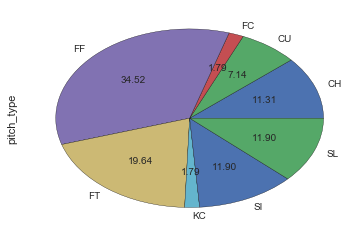

In [32]:
# ヒットにした変化球の割合(2015)
pitch_types_2015.plot.pie(autopct='%.2f')


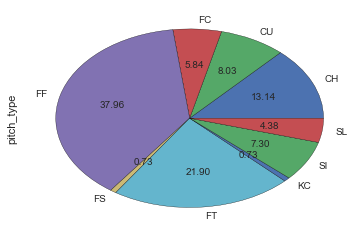

In [33]:
# 速球系を中心に打ち込んでいる、2016年は?
pitch_types_2016.plot.pie(autopct='%.2f')


In [34]:
# 多少変化球を打ってる以外変わらないかも...次はアウトになった時の変化球をみる
query_outs = QUERY_TEMPLATE.format(','.join(['2']))
votto_pitchfx_2015_outs = votto_pitchfx_2015.query(query_outs)
votto_pitchfx_2016_outs = votto_pitchfx_2016.query(query_outs)

In [35]:
# アウトの傾向を探ってみる. ヒットに仕留めた変化球ごとに集計してみる
pitch_types_2015_outs = votto_pitchfx_2015_outs.pitch_type.groupby(votto_pitchfx_2015_outs.pitch_type).count()
pitch_types_2016_outs = votto_pitchfx_2016_outs.pitch_type.groupby(votto_pitchfx_2016_outs.pitch_type).count()

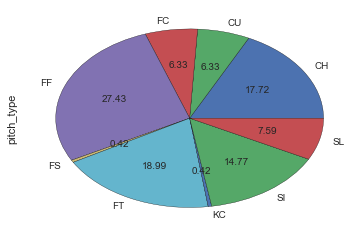

In [36]:
# アウトになった変化球の割合(2015)、速球系に苦戦してる
pitch_types_2015_outs.plot.pie(autopct='%.2f')

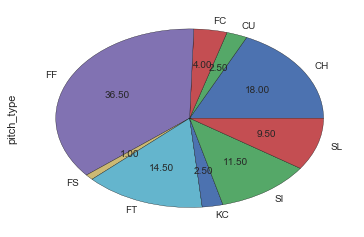

In [37]:
# アウトになった変化球の割合(2016)、変化球系にやられてる(ちょっと違いが出てきた！)
pitch_types_2016_outs.plot.pie(autopct='%.2f')

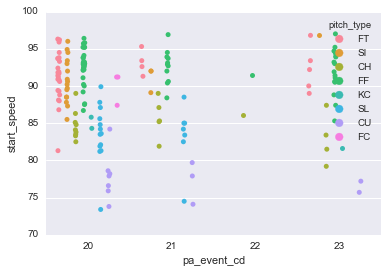

In [38]:
# さらに詳しく、ヒットの傾向をみてみる.

# X軸:球種 Y軸: 球速(初速)でヒット/アウトのゾーンを把握してみる

# pa_event_cd(打席でのイベントID):は、 20:単打, 21:二塁打, 22:三塁打, 23:本塁打

sns.stripplot(x='pa_event_cd', y='start_speed', data=votto_pitchfx_2015_hits,  hue='pitch_type', split=True, jitter=True)

In [39]:
# 同じ条件で2016年も見る
sns.stripplot(x='pitch_type', y='start_speed', data=ichiro_pitchfx_2016_hits,  hue='pa_event_cd', split=True, jitter=True)

NameError: name 'ichiro_pitchfx_2016_hits' is not defined

In [19]:
# 2016年の三塁打はCH(チェンジアップ)とFC(Cut Fastball)を打ち込んでるっぽい、興味深いので見てみる
ichiro_pitchfx_2016_hits.query('pa_event_cd == 22')

,Unnamed: 0,Unnamed: 0.1,retro_game_id,year,month,day,st_fl,regseason_fl,playoff_fl,game_type,game_type_des,local_game_time,game_id,home_team_id,away_team_id,home_team_lg,away_team_lg,interleague_fl,park_id,park_name,park_location,inning_number,bat_home_id,outs_ct,pit_mlbid,pit_first_name,pit_last_name,pit_box_name,pit_hand_cd,bat_mlbid,bat_first_name,bat_last_name,bat_box_name,bat_hand_cd,ab_number,start_bases,end_bases,event_outs_ct,pa_ball_ct,pa_strike_ct,pitch_seq,pa_terminal_fl,pa_event_cd,pitch_res,pitch_des,pitch_id,x,y,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,x0,y0,z0,vx0,vy0,vz0,ax,ay,az,break_y,break_angle,break_length,pitch_type,pitch_type_seq,type_confidence,zone,spin_dir,spin_rate,sv_id,game_day
723,362869,2904,ATL201607020,2016,7,2,F,T,F,R,Regular Season,16:10,448081,atl,mia,NL,NL,F,16,Turner Field,"Atlanta, GA",3,0,2,449173,Lucas,Harrell,"Harrell, L",R,400085,Ichiro,Suzuki,"Suzuki, I",L,19,_2_,__3,2,2,2,SSBBX,T,22,X,"In play, run(s)",144,140.98,179.89,82.8,77.4,3.39,1.46,-8.00,6.65,-0.629,2.181,-2.433,50.0,6.030,6.846,-121.087,-4.670,-12.064,20.291,-22.077,23.9,25.7,6.8,CH,FT|SL|CU|FT|CH,0.905,4.0,230.071,1884.877,160702_164701,2016-07-02
946,493517,2256,COL201608070,2016,8,7,F,T,F,R,Regular Season,14:10,448525,col,mia,NL,NL,F,19,Coors Field,"Denver, CO",7,0,1,543734,Chris,Rusin,Rusin,L,400085,Ichiro,Suzuki,"Suzuki, I",L,60,___,__3,1,2,0,BBX,T,22,X,"In play, no out",499,116.73,175.49,86.1,80.8,3.39,1.46,2.86,2.38,0.007,2.344,2.015,50.0,5.919,-5.971,-126.155,-3.343,4.691,21.671,-28.199,23.9,-7.4,7.1,FC,FC|SI|FC,0.894,5.0,130.278,707.097,160807_163801,2016-08-07
